In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install -q -U tfds-nightly

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

In [ ]:
list_ds = tf.data.Dataset.list_files('/content/drive/My Drive/Marmot/Marmot_data/*.xml')

# list_ds = tf.data.Dataset.list_files('/content/drive/My Drive/datasets/flipkart_grid/Marmot_data/*.xml')

In [ ]:
img_height, img_width = 256, 256

def normalize(input_image):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def decode_mask_img(img):
  # convert the compressed string to a 2D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=1)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
  file_path = tf.strings.regex_replace(file_path, '.xml', '.jpg')

  mask_file_path = tf.strings.regex_replace(file_path, '.jpg', '.jpeg')

  table_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'table_mask')
  column_mask_file_path = tf.strings.regex_replace(mask_file_path, 'Marmot_data', 'column_mask')

  img = normalize(decode_img(tf.io.read_file(file_path)))
  table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
  column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))

  return img, {"table_output" : table_mask, "column_output" : column_mask }

In [ ]:
# dataset = list_ds.map(process_path)

DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

train = list_ds.take(train_size)
test = list_ds.skip(train_size)

TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = train.shuffle(BUFFER_SIZE)

train = train.map(process_path,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

test = test.map(process_path)

train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Table Mask', 'Column Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

(256, 256, 3)


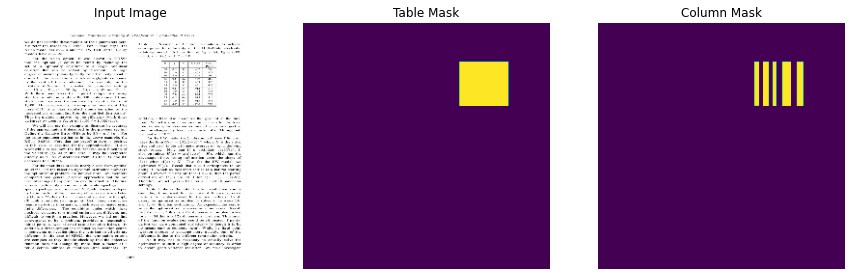

(256, 256, 3)


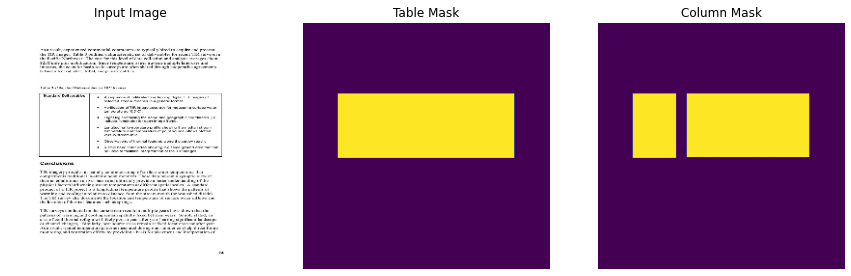

In [ ]:
for image, mask  in train.take(2):
  print(image.shape)
  # print(mask.shape)
  display([image, mask['table_output'], mask['column_output']])

In [ ]:
class TableNet:
  @staticmethod
  def build_table_decoder(inputs, pool3, pool4):
    x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', name='table_output') 
    
    x = last(x)

    return x

  @staticmethod
  def build_column_decoder(inputs, pool3, pool4):
    
    x = Conv2D(512, (1, 1), activation = 'relu', name='block7_conv1_column')(inputs)
    x = Dropout(0.8, name='block7_dropout_column')(x)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block8_conv1_column')(x)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])

    # concatenated = concatenate([x, pool4])

    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2,
      padding='same', name='column_output') 
    
    x = last(x)

    return x  

  @staticmethod
  def vgg_base(inputs):
    base_model = tf.keras.applications.vgg19.VGG19(
        input_shape=[256, 256, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)
  
  @staticmethod
  def build():
    inputShape = (256, 256, 3)

    inputs = Input(shape=inputShape, name='input')

    pool_layers = TableNet.vgg_base(inputs)

    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv1')(pool_layers[2])
    x = Dropout(0.8, name='block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
    x = Dropout(0.8, name = 'block6_dropout2')(x)
    
    table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1])
    column_mask = TableNet.build_column_decoder(x, pool_layers[0], pool_layers[1])

    model = Model(			
              inputs=inputs,
			        outputs=[table_mask, column_mask],
			        name="tablenet")
    
    return model

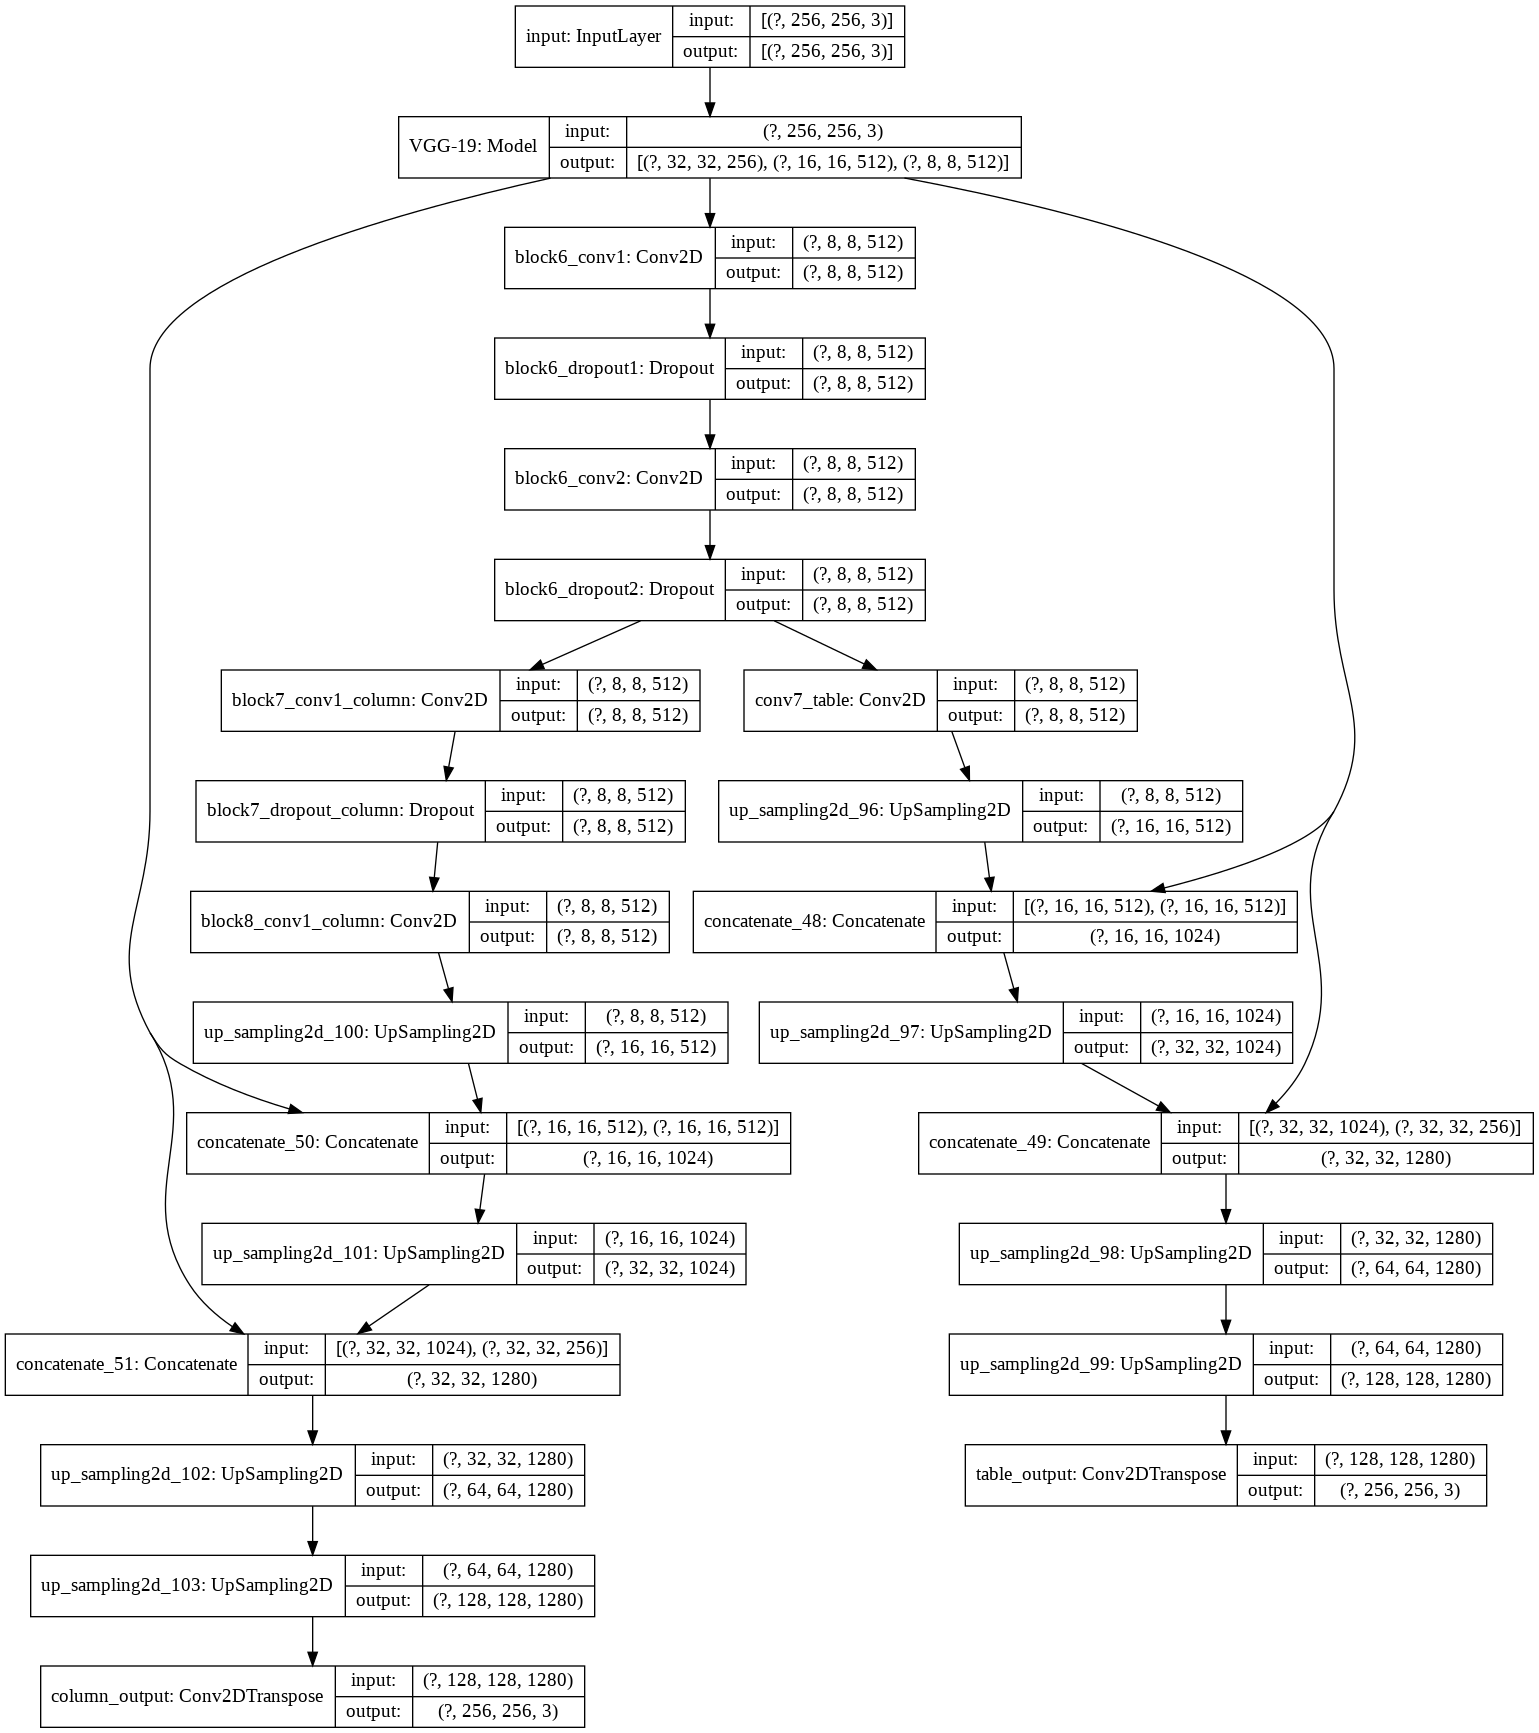

In [ ]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
losses = {
	"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	"column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_output": 1.0, "column_output": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask1, pred_mask2):
  pred_mask1 = tf.argmax(pred_mask1, axis=-1)
  pred_mask1 = pred_mask1[..., tf.newaxis]


  pred_mask2 = tf.argmax(pred_mask2, axis=-1)
  pred_mask2 = pred_mask2[..., tf.newaxis]
  return pred_mask1[0], pred_mask2[0]


In [ ]:
for image, mask in train_dataset.take(1):
  sample_image, sample_mask1, sample_mask2 = image, mask['table_output'], mask['column_output']

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, (mask1, mask2) in dataset.take(num):
      pred_mask1, pred_mask2 = model.predict(image, verbose=1)
      table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
      
      display([image[0], table_mask, column_mask])
  else:
    pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
    table_mask, column_mask = create_mask(pred_mask1, pred_mask2)

    display([sample_image[0], table_mask, column_mask])

1/1 [==============================] - 0s 1ms/step


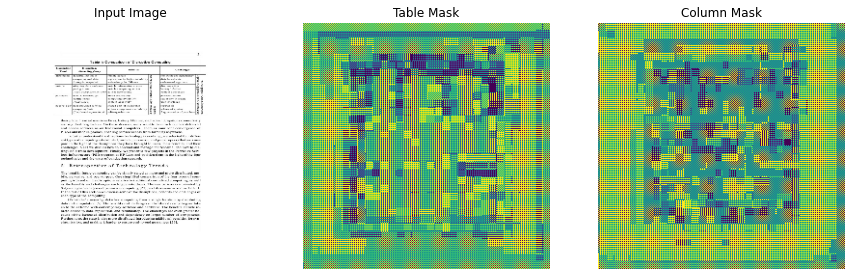

In [ ]:
show_predictions()

In [ ]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )

early_stoping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
    )



In [ ]:
EPOCHS = 5000
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS


model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), model_checkpoint])

1/1 [==============================] - 0s 2ms/step


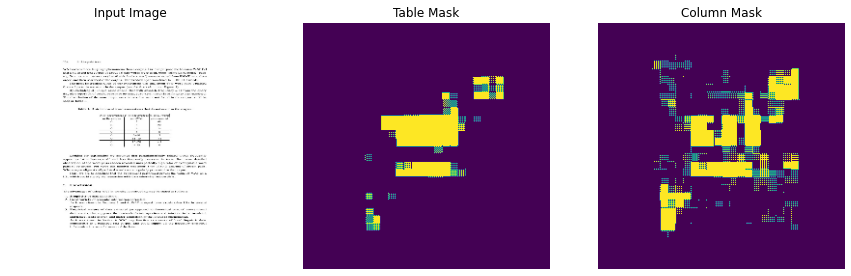

1/1 [==============================] - 0s 2ms/step


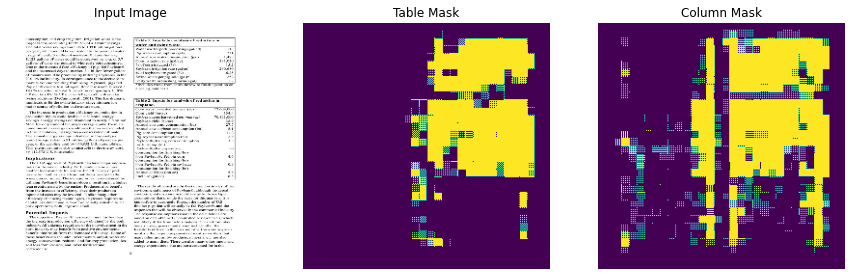

1/1 [==============================] - 0s 2ms/step


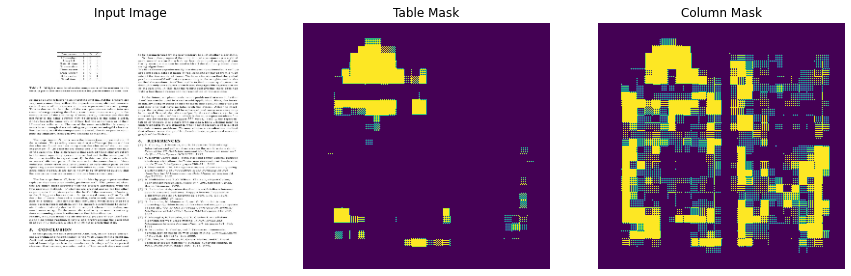

1/1 [==============================] - 0s 1ms/step


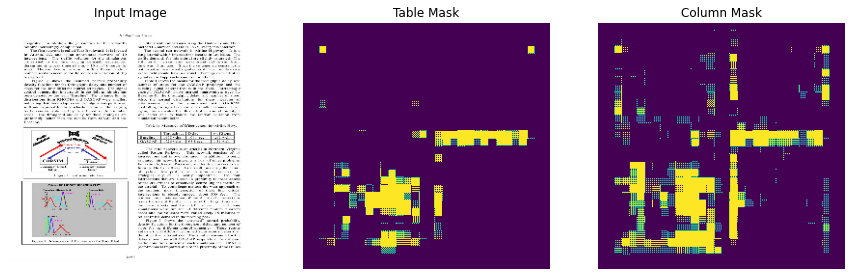

1/1 [==============================] - 0s 3ms/step


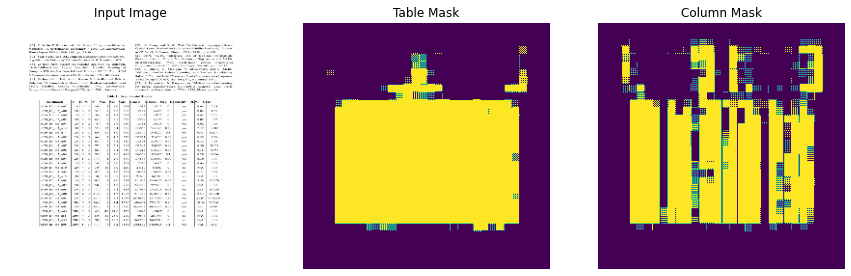

In [ ]:
show_predictions(train_dataset, 5)

In [ ]:
model.save('model_66')

INFO:tensorflow:Assets written to: model_66/assets


In [ ]:
!zip -r model66.zip model_66/

  adding: model_66/ (stored 0%)
  adding: model_66/saved_model.pb (deflated 91%)
  adding: model_66/variables/ (stored 0%)
  adding: model_66/variables/variables.data-00000-of-00002 (deflated 83%)
  adding: model_66/variables/variables.data-00001-of-00002 (deflated 8%)
  adding: model_66/variables/variables.index (deflated 74%)
  adding: model_66/assets/ (stored 0%)


In [ ]:
!cp model66.zip '/content/drive/My Drive/Marmot/'